<a href="https://colab.research.google.com/github/RK22000/Rahuls-Another-Motion-Picture-Review-Classifier/blob/freeplay/RAMPRC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Rahul
# Run this cell to connect your google drive to this notebooks runtime directory.
# The connection only lasts for your specific session so the cell will need to be run once at the start of every session
# It also means that we cant actually access each others google drive through the notebook
# To ensure that directory stuff works well lets agree to this directory structure within our google drives
# MyDrive is the root directory in google drive. From there 
# MyDrive/CS_156/assignment_2b1
# assignment_2b1 is the directory where we will have our data files and stuff stored or both of our google drives

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
# Rahul
import math

class DataPoint:
    def __init__(self, identifier=None, original_data_key=lambda data:data, label=None):
        self.identifier=identifier
        self.original_data_key=original_data_key
        self.label=label
        self.processed_data=None

    @property
    def original_data(self):
        return self.original_data_key(self.identifier)

class DataSet:
    def __init__(self, pos_data, neg_data, original_data_key=lambda data:data, 
                 preprocessor=None, tokenizer=None, token_thresh=0.75, usefull_token_delta=0.01, verbose=False):
        self.pos_data  = [ DataPoint(identifier=data, original_data_key=original_data_key, label=0) for data in pos_data ]
        self.neg_data  = [ DataPoint(identifier=data, original_data_key=original_data_key, label=1) for data in neg_data ]

        self.tokenizer = tokenizer
        self.preprocessor=preprocessor
        self.token_set = set()
        self.token_counter = dict() # Maps each token to a tupple that holds the number of times the token appears in a positive/negative review
                                    # token -> (pos_count, neg_count)

        all_data=self.pos_data+self.neg_data
        
        if verbose:
            print("Loading raw data")
        self.raw_pos_data=[]
        self.raw_neg_data=[]
        l_pos, l_neg = len(pos_data), len(neg_data)
        for i, data in enumerate(pos_data):
            if verbose:
                print(f'\tLoading raw positive data {i}/{l_pos}')
            self.raw_pos_data += [original_data_key(data)]
        for i, data in enumerate(neg_data):
            if verbose:
                print(f'\tLoading raw negative data {i}/{l_neg}')
            self.raw_neg_data += [original_data_key(data)]
        self.raw_data = self.raw_pos_data + self.raw_neg_data

        if preprocessor is None or tokenizer is None:
            return
        #############################################
        # Start preprocessing and tokenizing raw data
        #- - - - - - - - - - - - - - - - - - - - - - 
        if verbose:
            print("Pre-processing data points")
        for data_point, raw in zip(all_data, self.raw_data):
            if verbose:
                print(f'data point = {data_point.identifier}')
            processed_data = tokenizer( preprocessor( raw ) )
            data_point.processed_data = processed_data
            for token in set(processed_data):
                self.token_set.add(token)
                self.token_counter.setdefault(token, [0,0])[data_point.label] += 1
        
        if verbose:
            print("Tupifying token counts")
        for token in self.token_set:
            self.token_counter[token] = tuple(self.token_counter[token])

        #############################################
        # Calculating Utility
        #- - - - - - - - - - - - - - - - - - - - - - 
        if verbose:
            print("Calculating utility")

        self.token_utility = { token: self.get_usefulness(token=token, delta=usefull_token_delta) for token in self.token_set }
        max_utility_token = max(self.token_utility, key=lambda z: self.token_utility[z])
        max_utility = self.token_utility[max_utility_token]
        if verbose:
            print(f'Max Utility for :{max_utility_token} = {max_utility}')
            print("Filtering out top utility")
        self.top_tokens = [ token for token in self.token_set if self.token_utility[token] > token_thresh*max_utility ]
        if verbose:
            print("Sorting by utility")
        self.top_tokens.sort(key=lambda token: self.token_utility[token], reverse=True)
    
    def get_usefulness(self, token, delta=0.01):
        if(not token in self.token_set): return 0
        pos_token_freq = self.token_counter[token][0]
        neg_token_freq = self.token_counter[token][1]
        # Observation the smaller I make delta the larger the largest usefullness value
        return abs(math.log2( (pos_token_freq+delta) / (neg_token_freq+delta) ))

class DataSets:
    def __init__(self, 
                 pos_data, 
                 neg_data, 
                 data_key=lambda data:data,
                 preprocessor=lambda raw:raw, 
                 tokenizer=lambda *args:[], 
                 split_ratio=0.1, 
                 token_thresh=0.75, 
                 usefull_token_delta=0.01,
                 verbose=False):
        if verbose:
            print("making validation set")
        self.valid_set = DataSet(*extract_validation_data( (pos_data, neg_data), ratio=split_ratio ), 
                                 original_data_key=data_key, verbose=verbose )
        if verbose:
            print("making training set")
        self.train_set = DataSet(pos_data=pos_data, neg_data=neg_data, original_data_key=data_key, 
                                 tokenizer=tokenizer, preprocessor=preprocessor, 
                                 token_thresh=token_thresh, usefull_token_delta=usefull_token_delta, verbose=verbose)


In [ ]:
# Edward

import os

def read_paths_for_classifier():
    pos_reviews_folder = input("Path for folder containing positive reviews: ")
    neg_reviews_folder = input("Path for folder containing negative reviews: ")
    return pos_reviews_folder, neg_reviews_folder

def get_files_for_classifier(pos_reviews_folder, neg_reviews_folder):
    """
    Method to get the files containing positive and negative data.
    :param pos_reviews_folder: The folder containing positive data files.
    :param neg_reviews_folder: The folder containing positive data files.
    :returns: A tuple containg a list of positive files and a list of negative files
    """
    pos_reviews = []
    neg_reviews = []

    def get_files(folder):
        """
        Get the files in the folder
        """
        files = []
        if folder:
            for filename in os.listdir(folder):
                f = os.path.join(folder, filename)
                if os.path.isfile(f):
                    files.append(f)
        return files
    pos_reviews = get_files(pos_reviews_folder)
    neg_reviews = get_files(neg_reviews_folder)

    return (pos_reviews, neg_reviews)

def get_review(f_path):
    with open(f_path, "r") as f:
        rev = f.read()
    return rev

# Parameter is string
# Return value is a preprocessed strings (to lowered, removed special characters, etc)
def review_preprocess(review):
    # lowercase everything
    review = review.lower()

    review = review.split("\n")
    bad_chars = """.,(){}[]"'-:;?"""
    bad_words = ['&nbsp', '&quot', '&#137'] # Just some bad words I noticed in the data
    for i, line in enumerate(review):
        review[i] = " ".join([ word for word in line.split() if word not in bad_chars and word not in bad_words ])

    return review

def review_tokenizer(preproc_review, n=1):
    """Tokenize the preprocessed review
    :param preproc_review: the preprocessed review
    :returns: a list of tokens in the preprocessed review. words in the review and pairs of consecutive words in the review count as tokens"""
    tokens = []
    
    for line in preproc_review:
        words = line.split()
        for token_size in range(1, 1+min(n, len(words))):
            groups = [ words[offset:len(words)-token_size+1+offset] for offset in range(token_size) ]
            for token in zip(*groups):
                tokens.append(" ".join(token))
            
        #for word in words:
         #   tokens.append(word)
        #for pair in zip(words[:-1], words[1:]):
         #   tokens.append(pair)
        
    return tokens


In [ ]:
# Rahul
import random
def extract_validation_data(data, ratio=0.1):
  """Extracts (and removes) validation data from the given data in the given ratio
  data: tuple with positive data as the first element and negative data as the second element
  returns: The validation tuple"""
  p_data, n_data = data
  p_valid = random.sample( p_data, int( ratio*len(p_data) ) )
  for item in p_valid:
    p_data.remove(item)
  n_valid = random.sample( n_data, int( ratio*len(n_data) ) )
  for item in n_valid:
    n_data.remove(item)
  return (p_valid, n_valid)

In [87]:
# Roughly 15 sec, thresh 85%
# Roughly 17 sec, thresh 80%
pos_path = r"/content/drive/MyDrive/CS_156/assignment_2b1/Movie Reviews/pos"
neg_path = r"/content/drive/MyDrive/CS_156/assignment_2b1/Movie Reviews/neg"
pos_reviews, neg_reviews = get_files_for_classifier(pos_path, neg_path)
data_sets = DataSets(pos_data=pos_reviews,
                     neg_data=neg_reviews,
                     data_key=get_review,
                     preprocessor=review_preprocess,
                     tokenizer=lambda review: review_tokenizer(review, n=6),
                     verbose=True,
                     token_thresh=0.70)
train_set = data_sets.train_set
valid_set = data_sets.valid_set
token_set = train_set.token_set
top_tokens = train_set.top_tokens

print(f'''training positive reviews   = {len(train_set.pos_data)}
\t validation positive reviews = {len(valid_set.pos_data)}
training negative reviews   = {len(train_set.neg_data)}
\t validation negative reviews = {len(valid_set.neg_data)} ''')
open("allTokens.txt", "w").close()
with open("allTokens.txt", "a") as file:
    for token in token_set:
        file.write(str(token) + '\n')

print(f'''total tokens = {len(token_set)}
top tokens = {len(top_tokens)}''')

for i in range (10) :
    print(str(top_tokens[i]) + " " + str(train_set.token_utility[top_tokens[i]]))
print(f'Last one {top_tokens[-1]} {train_set.token_utility[top_tokens[-1]]}')

making validation set
Loading raw data
	Loading raw positive data 0/90
	Loading raw positive data 1/90
	Loading raw positive data 2/90
	Loading raw positive data 3/90
	Loading raw positive data 4/90
	Loading raw positive data 5/90
	Loading raw positive data 6/90
	Loading raw positive data 7/90
	Loading raw positive data 8/90
	Loading raw positive data 9/90
	Loading raw positive data 10/90
	Loading raw positive data 11/90
	Loading raw positive data 12/90
	Loading raw positive data 13/90
	Loading raw positive data 14/90
	Loading raw positive data 15/90
	Loading raw positive data 16/90
	Loading raw positive data 17/90
	Loading raw positive data 18/90
	Loading raw positive data 19/90
	Loading raw positive data 20/90
	Loading raw positive data 21/90
	Loading raw positive data 22/90
	Loading raw positive data 23/90
	Loading raw positive data 24/90
	Loading raw positive data 25/90
	Loading raw positive data 26/90
	Loading raw positive data 27/90
	Loading raw positive data 28/90
	Loading raw p

In [ ]:
import heapq
from heapq import *

class Model:
    def __init__(self, token_set, data_processor=None):
        """The model that will be trained with data. It will hold a token set as the set of posible evidences and it will know the conditional probabalities for each evidence token
        token_set: the set of significant tokens that the model should care about"""
        self.token_set = token_set
        self.cond_probabilities = {} # Map string to ( P(e|T), P(e|~T) )
        self.data_processor = data_processor
    
    def is_pos_review(self, review, threshold=1.0):
        """Method to ask model to predict wheter the movie review is positive or negative"""
        return self.prob_pos_review(review)>threshold
    
    def prob_pos_review(self, review):
        review = self.data_processor(review)
        score = 1
        cond_probabilities = self.cond_probabilities
        for token in review:
            if token in self.token_set:
                post_pos, post_neg = cond_probabilities[token]
                score *= (post_pos/post_neg)
        return score
    
    def get_top_evidences(self, n=5):
        """Method to get the strongest n evidences for positive and negative reviews"""
        top_pos = heapq.nlargest( n=n, iterable=self.token_set, key=lambda token:self.cond_probabilities[token][0] )
        top_neg = heapq.nlargest( n=n, iterable=self.token_set, key=lambda token:self.cond_probabilities[token][1] )
        return top_pos, top_neg        

    # https://rkan-sjsu.atlassian.net/browse/AMPRC-13
    def print_top_evidences(self, n=5):
        top_pos, top_neg = self.get_top_evidences(n=5)

        print(f"Top {n} Positive Evidences:")
        for i, evidence in enumerate(top_pos):
            print(f"P{i+1}: {evidence}, probs={self.cond_probabilities[evidence]}")

        print(f"Top {n} Negative Evidences:")
        for i, evidence in enumerate(top_neg):
            print(f"N{i+1}: {evidence}, probs={self.cond_probabilities[evidence]}")
    
    # Issue: https://rkan-sjsu.atlassian.net/browse/AMPRC-12
    def store_model_as_file(self):
        # clears the file
        open("bayesian_model.txt", "w").close()

        my_file = open("bayesian_model.txt", "a")
        for evidence in self.cond_probabilities:
            my_file.write(f"{evidence}: {self.cond_probabilities[evidence][0]} present if positive review, "
                          f"{self.cond_probabilities[evidence][1]} present if negative review")
            my_file.write("\n")
        my_file.close()

class Trainer:
    """This class will train the model by setting the probabality values in the model"""
    def __init__(self, train_set):
        """model: the model to train
        train_set: DataSet object that contains the training data"""
        processor = lambda data: train_set.tokenizer(train_set.preprocessor(data))
        self.model = Model(set(train_set.top_tokens), data_processor=processor)
        self.train_set = train_set
        self.data_processor = processor
    
    def token_cond_probs(self, token, delta=0.01):
        """Method to get the probabality of token being present in a reviews post positive review and post negative review
        token: the string evidence word
        delta: the smoothing constant added to the numerator and denominator in calculating the probabalitites
        returns: tuple of the post positive and post negative review"""
        #prob_post_pos = (delta + len( [ review for review in self.train_set.pos_data if token in review.processed_data ] ) )/ (delta + len( self.train_set.pos_data ) )
        #prob_post_neg = (delta + len( [ review for review in self.train_set.neg_data if token in review.processed_data ] ) )/ (delta + len( self.train_set.neg_data ) )
        token_counter=self.train_set.token_counter
        prob_post_pos = (delta + token_counter[token][0] )/ (delta + len( self.train_set.pos_data ) )
        prob_post_neg = (delta + token_counter[token][1] )/ (delta + len( self.train_set.neg_data ) )
        return prob_post_pos, prob_post_neg
        

    def train(self, verbose=False):
        """Method to train the model
        verbose: print updates as the model is being trained"""
        indent = ""
        def verbate(msg):
            print(indent + msg)
        if verbose:
            verbate("Training Model")
            indent += "\t"
            verbate("Calculating post positive and post negative probabalities")
            indent += '\t'
        cond_probabilities = self.model.cond_probabilities
        token_cond_probs = self.token_cond_probs
        for i, token in enumerate(self.model.token_set):
            cond_probabilities[token] = token_cond_probs(token)
            if verbose:
                verbate(f'Conditional probabalities for {i+1}. {token} = {cond_probabilities[token]}')
        
        if verbose:
            indent=""
            verbate("Done training")


In [88]:
trainer = Trainer(train_set=train_set)
trainer.train(verbose=True)
model = trainer.model

Streaming output truncated to the last 5000 lines.
		Conditional probabalities for 12863. beauty that = (0.003716003506129554, 1.2345526598437056e-05)
		Conditional probabalities for 12864. dumb as = (1.2345526598437056e-05, 0.003716003506129554)
		Conditional probabalities for 12865. frightening in = (0.003716003506129554, 1.2345526598437056e-05)
		Conditional probabalities for 12866. from the people = (0.003716003506129554, 1.2345526598437056e-05)
		Conditional probabalities for 12867. and jeffrey reddick = (0.003716003506129554, 1.2345526598437056e-05)
		Conditional probabalities for 12868. your hard-earned = (1.2345526598437056e-05, 0.006185108825816965)
		Conditional probabalities for 12869. reality of the = (0.0049505561659732595, 1.2345526598437056e-05)
		Conditional probabalities for 12870. chubby = (0.007419661485660671, 1.2345526598437056e-05)
		Conditional probabalities for 12871. looks cool = (1.2345526598437056e-05, 0.003716003506129554)
		Conditional probabalities for 128

In [89]:
model.print_top_evidences()
model.store_model_as_file()

Top 5 Positive Evidences:
P1: perfect for, probs=(0.02223429340378514, 1.2345526598437056e-05)
P2: witty and, probs=(0.01976518808409773, 1.2345526598437056e-05)
P3: well worth, probs=(0.017296082764410317, 1.2345526598437056e-05)
P4: is excellent, probs=(0.017296082764410317, 1.2345526598437056e-05)
P5: characters with, probs=(0.017296082764410317, 1.2345526598437056e-05)
Top 5 Negative Evidences:
N1: this mess, probs=(1.2345526598437056e-05, 0.025937951383316258)
N2: this turkey, probs=(1.2345526598437056e-05, 0.02223429340378514)
N3: & robin, probs=(1.2345526598437056e-05, 0.017296082764410317)
N4: batman & robin, probs=(1.2345526598437056e-05, 0.017296082764410317)
N5: batman &, probs=(1.2345526598437056e-05, 0.017296082764410317)


In [ ]:
import matplotlib.pyplot as plt

class Tester:
    def __init__(self, model, valid_set):
        self.model = model
        self.valid_set = valid_set
        
    def test(self, threshold=1.0, verbose=False):
        def verbate(msg):
            if verbose:
                print(msg)
        
        verbate(f"Testing threshold: {threshold}")
        true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
        is_pos = self.model.is_pos_review
        l_pos, l_neg = len(self.valid_set.raw_pos_data), len(self.valid_set.raw_neg_data)
        for i, review in enumerate(self.valid_set.raw_pos_data):
            verbate(f'\ttesting pos case {i}/{l_pos}')
            if is_pos(review=review, threshold=threshold): true_pos+=1
            else: false_neg+=1
        for i, review in enumerate(self.valid_set.raw_neg_data):
            verbate(f'\ttesting neg case {i}/{l_neg}')
            if not is_pos(review=review, threshold=threshold): true_neg+=1
            else: false_pos+=1
        total_tests = true_pos + true_neg + false_pos + false_neg
        accuracy, tpr, tnr = (true_pos+true_neg)/total_tests, true_pos/(true_pos+false_pos), true_neg/(true_neg+false_neg)
        return accuracy, tpr, tnr
    
    def plot_thresholds(self, thresholds, verbose=False):
        results = [ self.test(threshold=thresh, verbose=verbose) for thresh in thresholds ]
        accus, tprs, tnrs = zip(*results)
        plt.plot(thresholds, accus, "ro-", label="accuracy")
        plt.legend()
        #plt.plot(thresholds, t)
    
    def plot_scores(self, verbose=False):
        prob_pos = self.model.prob_pos_review
        x_pos, x_neg = 1, 0
        y_pos = [prob_pos(review) for review in self.valid_set.raw_pos_data ]#if prob_pos(review) < 7]
        y_neg = [prob_pos(review) for review in self.valid_set.raw_neg_data ]#if prob_pos(review) < 0.8]
        plt.plot([x_pos]*len(y_pos), y_pos, "g.", label="positive reviews")
        plt.plot([x_neg]*len(y_neg), y_neg, "r.", label="negative reviews")
        
        

    

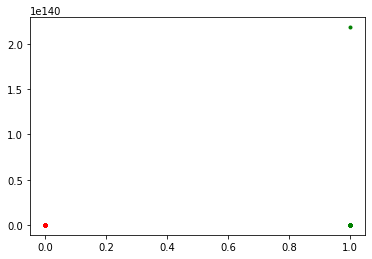

In [ ]:
tester = Tester(model, data_sets.valid_set)
tester.plot_scores()

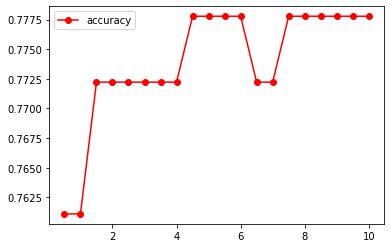

In [94]:
# ~10sec
import numpy as np
tester = Tester(model, data_sets.valid_set)
tester.plot_thresholds(np.linspace(start=0.5, stop=10, num=20), verbose=False)

In [97]:
# accuracy, tpr, tnr
tester = Tester(model, data_sets.valid_set)
tester.test(threshold=1.2)

(0.7611111111111111, 0.7008547008547008, 0.873015873015873)